In [1]:
import math
import time
import matplotlib.pyplot as plt
import torch
import trimesh

from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)

import torch
import torch.nn.functional as F
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.io import load_obj
from pytorch3d.structures import (
    Pointclouds,
    Meshes,
)
from pytorch3d.renderer.blending import BlendParams
from pytorch3d.renderer import TexturesVertex
from src.render.points_renderer import PointsRenderer
from src.render.pulsar_renderer import PulsarRenderer
from src.config import get_parser
from src.blueprint_sampler import BlueprintSampler
from src.util import grid_to_list

In [2]:
# Set the cuda device
device = torch.device("cuda:0")
torch.cuda.set_device(device)

bs = 1
    
config = get_parser().parse_args(args=[])

config.raster_image_size = 512
d_size = 1024
config.data_blueprint = f'blueprint_radial_{d_size}.npz'
config.data_blueprint_size = d_size
config.data_patch_size = d_size
blueprintSampler = BlueprintSampler(config)
res = blueprintSampler(bs)
points = res['points']
normals = res['normals']
faces = res['faces']

points = grid_to_list(points).to(device)
normals = grid_to_list(normals).to(device)
#faces = faces.to(device)

points.shape, normals.shape, faces.shape

(torch.Size([1, 1048576, 3]),
 torch.Size([1, 1048576, 3]),
 torch.Size([1, 2093058, 3]))

In [3]:
from src.util import make_faces
vertices = points[0].cpu().numpy()
#faces = blueprintSampler.faces[0].cpu().numpy()
faces = make_faces(config.data_patch_size, config.data_patch_size)
mesh = trimesh.Trimesh(vertices=vertices, 
                       faces=faces, 
                       process=False
                      )
#mesh.export('./face_tris1.stl');
mesh.show(viewer='gl')

SceneViewer(width=1848, height=1016)

In [4]:
# parser.add_argument('--raster_radius', type=float, default=0.01, 
#                     help='Points radius')
# parser.add_argument('--raster_points_per_pixel', type=int, default=4)
config.raster_image_size = 512
config.raster_radius = 0.01
config.raster_points_per_pixel = 4
config.raster_radius, config.raster_points_per_pixel

(0.01, 4)

In [5]:
R = PointsRenderer(config)
R.setup(device)
R = R.to(device)

1.3080403804779053


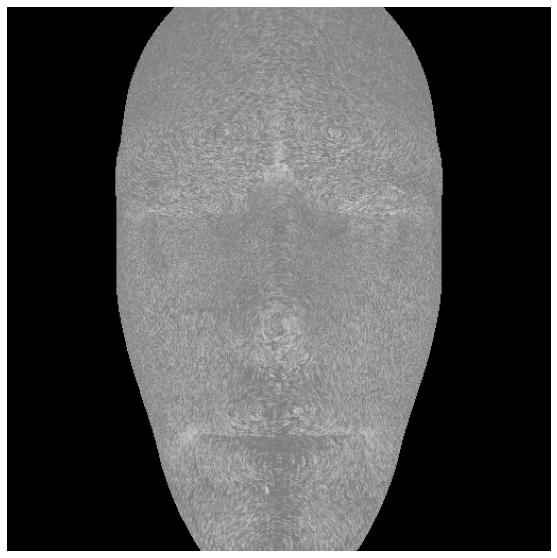

In [6]:
cal_normals = R.vrt_nrm.vertex_normals_mean(points)
cal_normals
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

0.23584651947021484


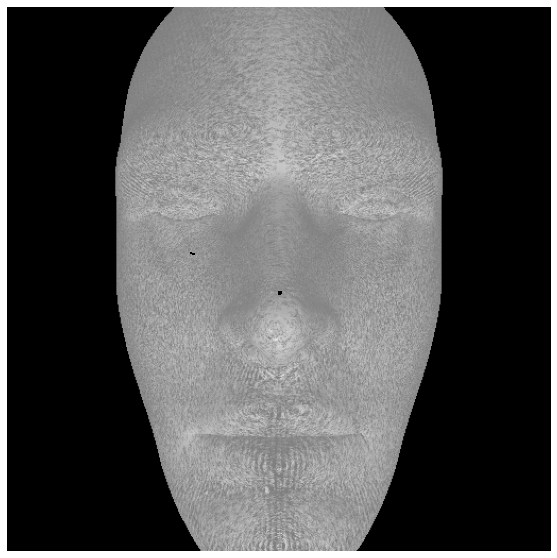

In [7]:
cal_normals = R.vrt_nrm.vertex_normals_weighted_area(points)
cal_normals
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

0.23104500770568848


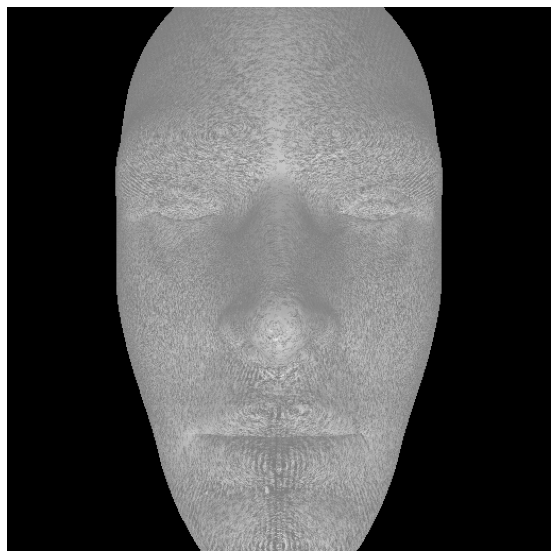

In [8]:
cal_normals = R.vrt_nrm.vertex_normals_fast(points)
cal_normals
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

0.2360217571258545


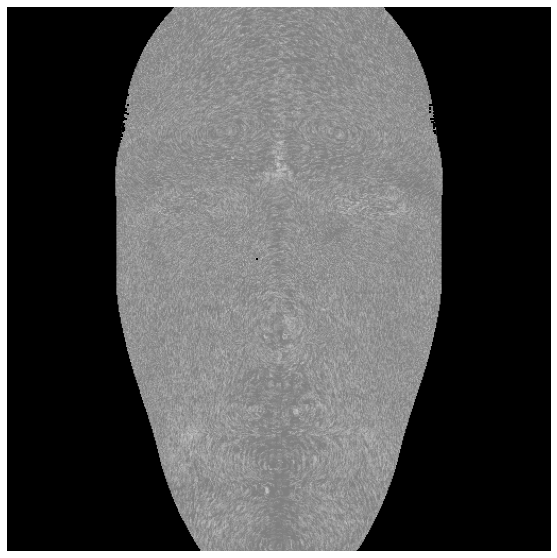

In [9]:
cal_normals = R.vrt_nrm.vertex_normals_weighted_angles(points)
cal_normals
start_time = time.time()
images = R(points, normals=cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

0.24205780029296875


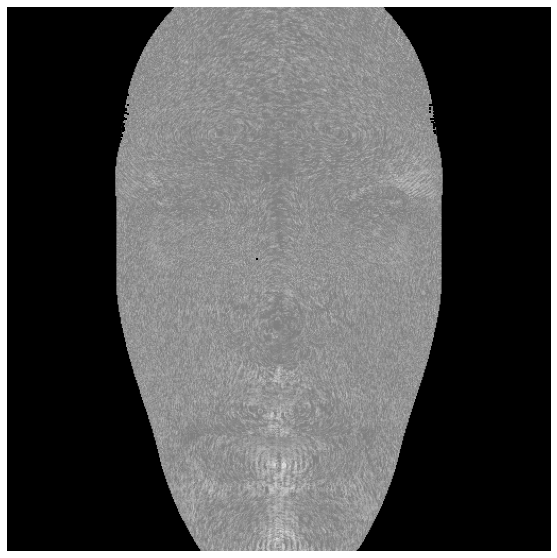

In [11]:
cal_normals = R.vrt_nrm.vertex_normals_weighted_angles(points)
cal_normals
start_time = time.time()
images = R(points, normals=-cal_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

0.7436518669128418


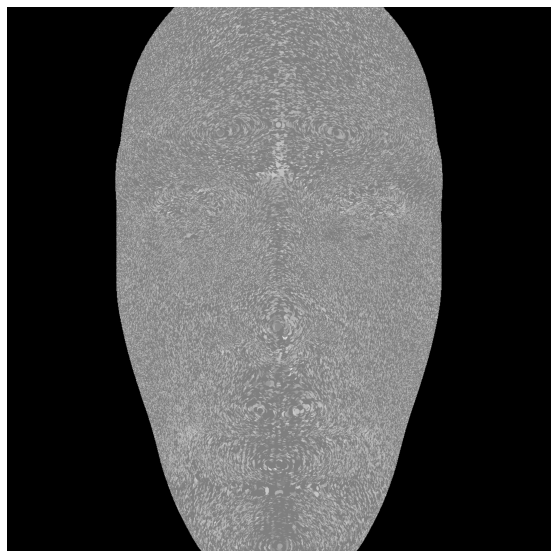

In [47]:
vertex_normals = mesh.vertex_normals
vertex_normals = torch.tensor(vertex_normals.copy()).float().to(device)[None]
vertex_normals.shape

start_time = time.time()
images = R(points, normals=vertex_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [10]:
mesh_vertices = torch.tensor(mesh.vertices.copy()).float().to(device)[None]
vertex_normals.shape

start_time = time.time()
images = R(mesh_vertices, normals=vertex_normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

NameError: name 'vertex_normals' is not defined

0.2441084384918213


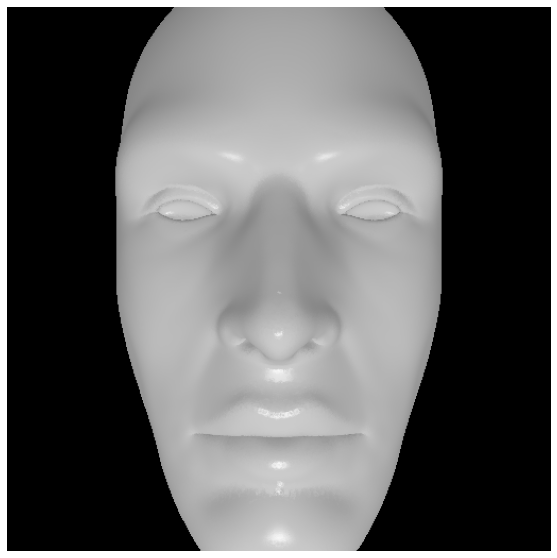

In [11]:
start_time = time.time()
images = R(points, normals=normals)
print(time.time() - start_time)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

TrackedArray([[-0.38012475, -0.36760139,  0.00738615],
              [-0.37672997, -0.37263745,  0.00782553],
              [-0.3733477 , -0.37768537,  0.00806919],
              ...,
              [ 0.49341825,  0.47739068,  0.00765734],
              [ 0.49328724,  0.47877693,  0.00833367],
              [ 0.49315655,  0.48015964,  0.00900829]])

0.7402815818786621


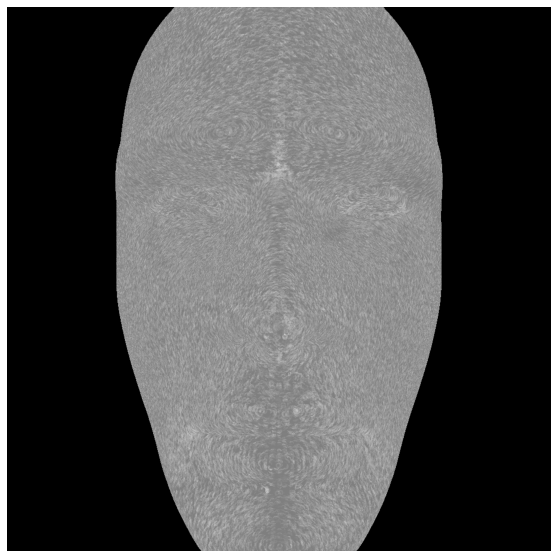

In [12]:
R.vrt_nrm.vert_tri_weights

tensor([[[[1.],
          [1.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[1.],
          [1.],
          [1.],
          [0.],
          [0.],
          [0.]],

         [[1.],
          [1.],
          [1.],
          [0.],
          [0.],
          [0.]],

         ...,

         [[1.],
          [1.],
          [1.],
          [0.],
          [0.],
          [0.]],

         [[1.],
          [1.],
          [1.],
          [0.],
          [0.],
          [0.]],

         [[1.],
          [1.],
          [0.],
          [0.],
          [0.],
          [0.]]]], device='cuda:0')